# ResOpsPT: attributes GRanD
***

***Author:** Chus Casado Rodríguez*<br>
***Date:** 03-04-2025*<br>

**Introduction:**<br>
This notebook loads the Portugeues reservoirs extracted from HDMS ([1_download_hdms.ipynb](./1_download_hdms.ipynb)) and extracts the correspoding GRanD attributes.

The raw point shapefile generated in [1_download_hdms.ipynb](./1_download_hdms.ipynb) was treated on GIS to manually find the GRanD ID of each of the reservoirs.

In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import Point
from shapely.geometry import box
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

from lisfloodreservoirs.utils.utils import filter_reservoirs, remove_duplicates
from lisfloodreservoirs.utils import DatasetConfig

## Configuration

In [3]:
cfg = DatasetConfig('config_dataset.yml')

# PATH_HDMS = Path('Z:/nahaUsers/casadje/datasets/hDMS/reservoir')

print(f'Attributes will be saved in {cfg.PATH_ATTRS}')

Attributes will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsPT\v1.0\attributes


## Reservoirs

In [18]:
# load reservoir shapefile
reservoirs = gpd.read_file(cfg.PATH_RESOPS / 'GIS' / 'reservoirs_HDMS+GRAND.shp')
# remove those without associated GRanD ID
reservoirs = reservoirs[reservoirs.GRAND_ID.notnull()]
reservoirs.GRAND_ID = reservoirs.GRAND_ID.astype(int)
reservoirs.set_index('GRAND_ID', drop=True, inplace=True)

print('HDMS')
print('-----')
print('No. reservoirs:\t{0}\nNo. attributes:\t{1}\n'.format(*reservoirs.shape))

HDMS
-----
No. reservoirs:	17
No. attributes:	29



## GRanD

GRanD
-----
No. reservoirs:	56
No. attributes:	58

56 out of 56 reservoirs exceed the minimum catchment area of 25 km2 (0 missing values)
56 out of 56 reservoirs exceed the minimum reservoir volume of 10 hm3 (0 missing values)
56 out of 56 reservoirs exceed the minimum catchment area (25 km2) and the minimum reservoir volume (10 hm3)


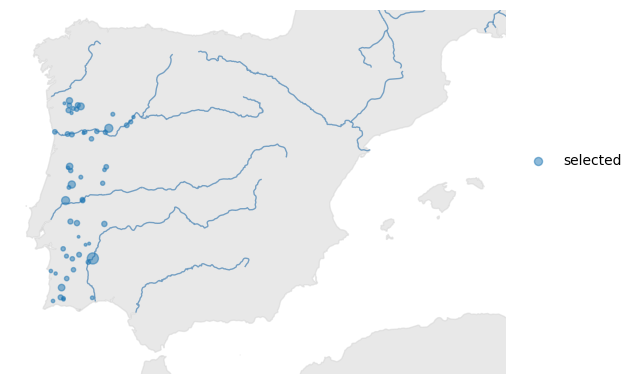

In [17]:
# load shapefile of dams
grand = gpd.read_file(cfg.PATH_GRAND / 'GRanD_dams_v1_3.shp').set_index('GRAND_ID')

# filter dams in the country
grand = grand.loc[grand.COUNTRY.str.lower() == 'portugal']

# correct names
grand.DAM_NAME = grand.DAM_NAME.str.upper()
grand.RES_NAME = grand.RES_NAME.str.upper()
grand.ADMIN_UNIT = grand.ADMIN_UNIT.str.upper()

# rename columns
grand.rename(columns={'LON_DD': 'LON', 'LAT_DD': 'LAT'}, inplace=True)

print('GRanD')
print('-----')
print('No. reservoirs:\t{0}\nNo. attributes:\t{1}\n'.format(*grand.shape))

# select reservoirs based on catchment area and reservoir volume
mask_grand = filter_reservoirs(grand.CATCH_SKM, grand.CAP_MCM, cfg.MIN_AREA, cfg.MIN_VOL)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5, zorder=0)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m', edgecolor='steelblue', facecolor='none'),
               linewidth=1, alpha=0.7, zorder=1)
if not mask_grand.all():
    grand.loc[~mask_grand].plot(markersize=grand.CAP_MCM**.5, c='indianred', alpha=.5, ax=ax, label='discarded')
grand.loc[mask_grand].plot(markersize=grand.CAP_MCM**.5, alpha=.5, ax=ax, label='selected')
ax.set_extent([-10, 5, 35.5, 44])
fig.legend(frameon=False, bbox_to_anchor=[1, .4, .1, .2])
ax.axis('off');

# apply the selection
# grand = grand.loc[mask_grand]

### Reservoir use

In [19]:
# rename columns
rename_uses_grand = {'USE_IRRI': 'irrigation',
                     'USE_ELEC': 'hydropower',
                     'USE_SUPP': 'supply',
                     'USE_FCON': 'flood',
                     'USE_RECR': 'recreation',
                     'USE_NAVI': 'navigation',
                     'USE_FISH': 'fish',
                     'USE_PCON': 'pollution',
                     'USE_LIVE': 'livestock',
                     'USE_OTHR': 'other'}
grand.rename(columns=rename_uses_grand, inplace=True)

# replace values in 'MAIN_USE' to be consistent with the columns
grand.MAIN_USE.replace({'Irrigation': 'irrigation',
                        'Hydroelectricity': 'hydropower',
                        'Water supply': 'supply',
                        'Other': 'other',
                        'Recreation': 'recreation',
                        'Flood control': 'flood'},
                       inplace=True)

# convert to boolean
grand_uses = list(rename_uses_grand.values())
grand[grand_uses] = grand[grand_uses].replace({'Main': True, 'Major': True, 'Sec': True, None: False})

# identify single purpose reservoirs
grand['SINGLE_USE'] = False
mask_singleuse = grand[grand_uses].sum(axis=1) == 1
grand.loc[mask_singleuse, 'SINGLE_USE'] = True

**Main use**

In [20]:
mask_singleuse = grand.SINGLE_USE
mask_hdcc = ~grand.index.isnull()

mainuse_singlepurpose = grand.loc[mask_hdcc & mask_singleuse, 'MAIN_USE'].value_counts()
mainuse_multipurpose = grand.loc[mask_hdcc, 'MAIN_USE'].value_counts()
mainuse_summary_grand = pd.concat((mainuse_singlepurpose, mainuse_multipurpose), axis=1)
mainuse_summary_grand.columns = ['singlepurpose', 'multipurpose']
mainuse_summary_grand.sort_values('multipurpose', ascending=False, inplace=True)
del mainuse_singlepurpose, mainuse_multipurpose

**All uses**

In [21]:
alluses_singlepurpose = grand.loc[mask_hdcc & mask_singleuse, grand_uses].sum()
alluses_multipurpose = grand.loc[mask_hdcc, grand_uses].sum()
alluses_summary_grand = pd.concat((alluses_singlepurpose, alluses_multipurpose), axis=1)
alluses_summary_grand.columns = ['singlepurpose', 'multipurpose']
alluses_summary_grand.sort_values('multipurpose', ascending=False, inplace=True)
alluses_summary_grand.dropna(axis=0, how='all', inplace=True)
alluses_summary_grand = alluses_summary_grand[~(alluses_summary_grand == 0).all(axis=1)]
del alluses_singlepurpose, alluses_multipurpose

## Export

In [22]:
# convert boolean fields to 0-1
bool_cols = list(rename_uses_grand.values()) + ['SINGLE_USE']
grand[bool_cols] = grand[bool_cols].astype(bool).astype(int)

# attributes to be included from GRAND
grand.columns = grand.columns.str.upper()
cols_grand = ['DAM_NAME', 'YEAR', 'REM_YEAR',
              'DAM_HGT_M', 'DAM_LEN_M', 'AREA_SKM', 'CAP_MCM', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM',
              'irrigation', 'hydropower', 'supply', 'flood', 'recreation', 'navigation', 'fish', 'pollution', 'livestock', 'other', 'MAIN_USE', 'SINGLE_USE','LAKE_CTRL']
cols_grand = [col.upper() for col in cols_grand]

# export as CSV
grand.loc[reservoirs.index, cols_grand].to_csv(cfg.PATH_ATTRS / 'grand.csv')